In [1]:
import pandas as pd
from pandas import DataFrame
import numpy as np

#importing libraries for graphical representation
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,7)
plt.style.use('fivethirtyeight')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import seaborn as sns

#imported library for date,time variables
from datetime import datetime, timedelta

#importing libraries necessary for model creation
from statsmodels.tsa.arima_model import ARIMA                 #library for ARIMA model implementation
from statsmodels.tsa.statespace.sarimax import SARIMAX        #library for SARIMAX model implementation
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf #library imported for plotting ACG and PACF graphs
from statsmodels.tsa.stattools import adfuller                #library to compute with ADFuller test

#importing library for seasonal decomposition implementation
from statsmodels.tsa.seasonal import seasonal_decompose

from scipy import stats
import statsmodels.api as sm
from itertools import product

import warnings
warnings.filterwarnings('ignore')

In [2]:
parsedates = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
#Reading CSV file
df = pd.read_csv('BTC-USD.csv', parse_dates=['Date'], index_col='Date', date_parser=parsedates) 
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [3]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-02-15,42586.464844,44667.218750,42491.035156,44575.203125,44575.203125,22721659051
2022-02-16,44578.277344,44578.277344,43456.691406,43961.859375,43961.859375,19792547657
2022-02-17,43937.070313,44132.972656,40249.371094,40538.011719,40538.011719,26246662813
2022-02-18,40552.132813,40929.152344,39637.617188,40030.976563,40030.976563,23310007704
2022-02-19,40022.132813,40246.027344,40010.867188,40126.429688,40126.429688,22263900160


In [7]:

# dropping all the columns that are not necessary for the predictions work[1]
df.drop(['Adj Close', 'Volume'],axis=1,inplace=True)

In [8]:
df.head()

,Open,High,Low,Close
Date,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015
2014-09-18,456.859985,456.859985,413.104004,424.440002
2014-09-19,424.102997,427.834991,384.532013,394.795990
2014-09-20,394.673004,423.295990,389.882996,408.903992
2014-09-21,408.084991,412.425995,393.181000,398.821014


In [9]:
df_mth = df.resample('M').mean()

Augmented Dickey Fuller(ADF) test result: p = 0.998077 


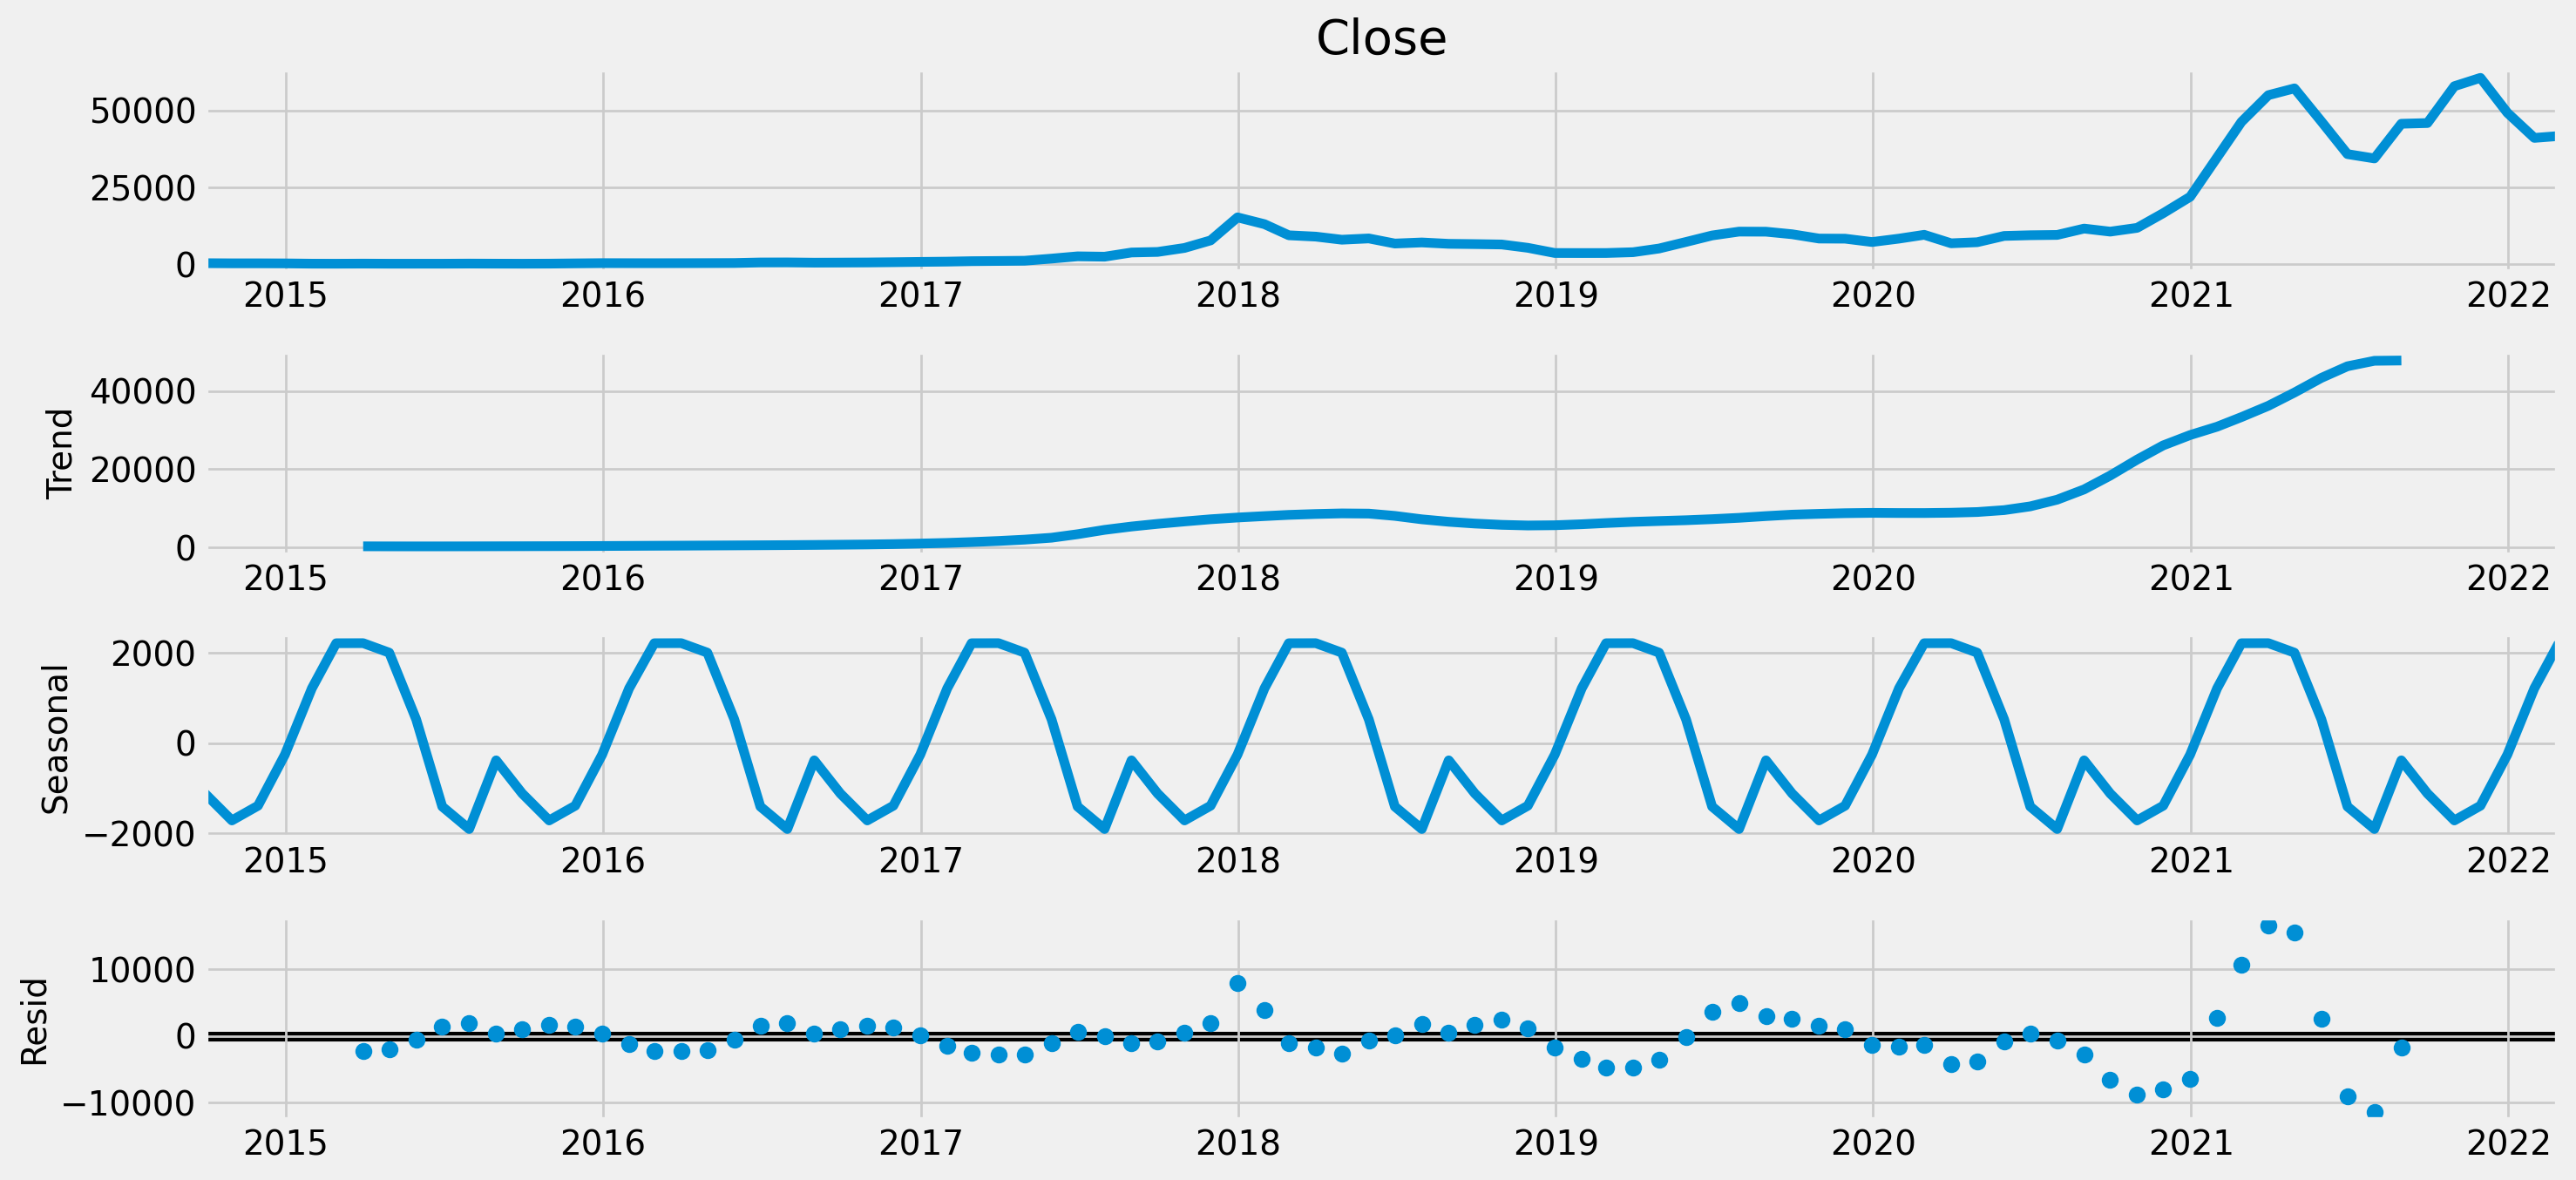

In [11]:
seasonal_decompose(df_mth.Close).plot() #[3]
#simultaneous printing and computation ADF test
print("Augmented Dickey Fuller(ADF) test result: p = %f " % adfuller(df_mth.Close)[1])
plt.show()

In [14]:
df_mth['close_box'], lmbda = stats.boxcox(df_mth.Close)
#simultaneous printing and computation ADF test
print("Augmented Dickey Fuller(ADF) test result: p =%f" % adfuller(df_mth.close_box)[1])

Augmented Dickey Fuller(ADF) test result: p =0.848060


In [15]:
df_mth['box_diff_seasonal_12'] = (df_mth.close_box - df_mth.close_box.shift(12))
#simultaneous printing and computation ADF test
print("Augmented Dickey Fuller(ADF) test result: p = %f" % adfuller(df_mth.box_diff_seasonal_12[12:])[1])

Augmented Dickey Fuller(ADF) test result: p = 0.093184


In [16]:
df_mth['box_diff_seasonal_3'] = df_mth.close_box - df_mth.close_box.shift(3)
#simultaneous printing and computation ADF test
print("Augmented Dickey Fuller(ADF) test result: p = %f" % adfuller(df_mth.box_diff_seasonal_3[3:])[1])

Augmented Dickey Fuller(ADF) test result: p = 0.004621


Augmented Dickey Fuller(ADF) test result: p = 0.001071


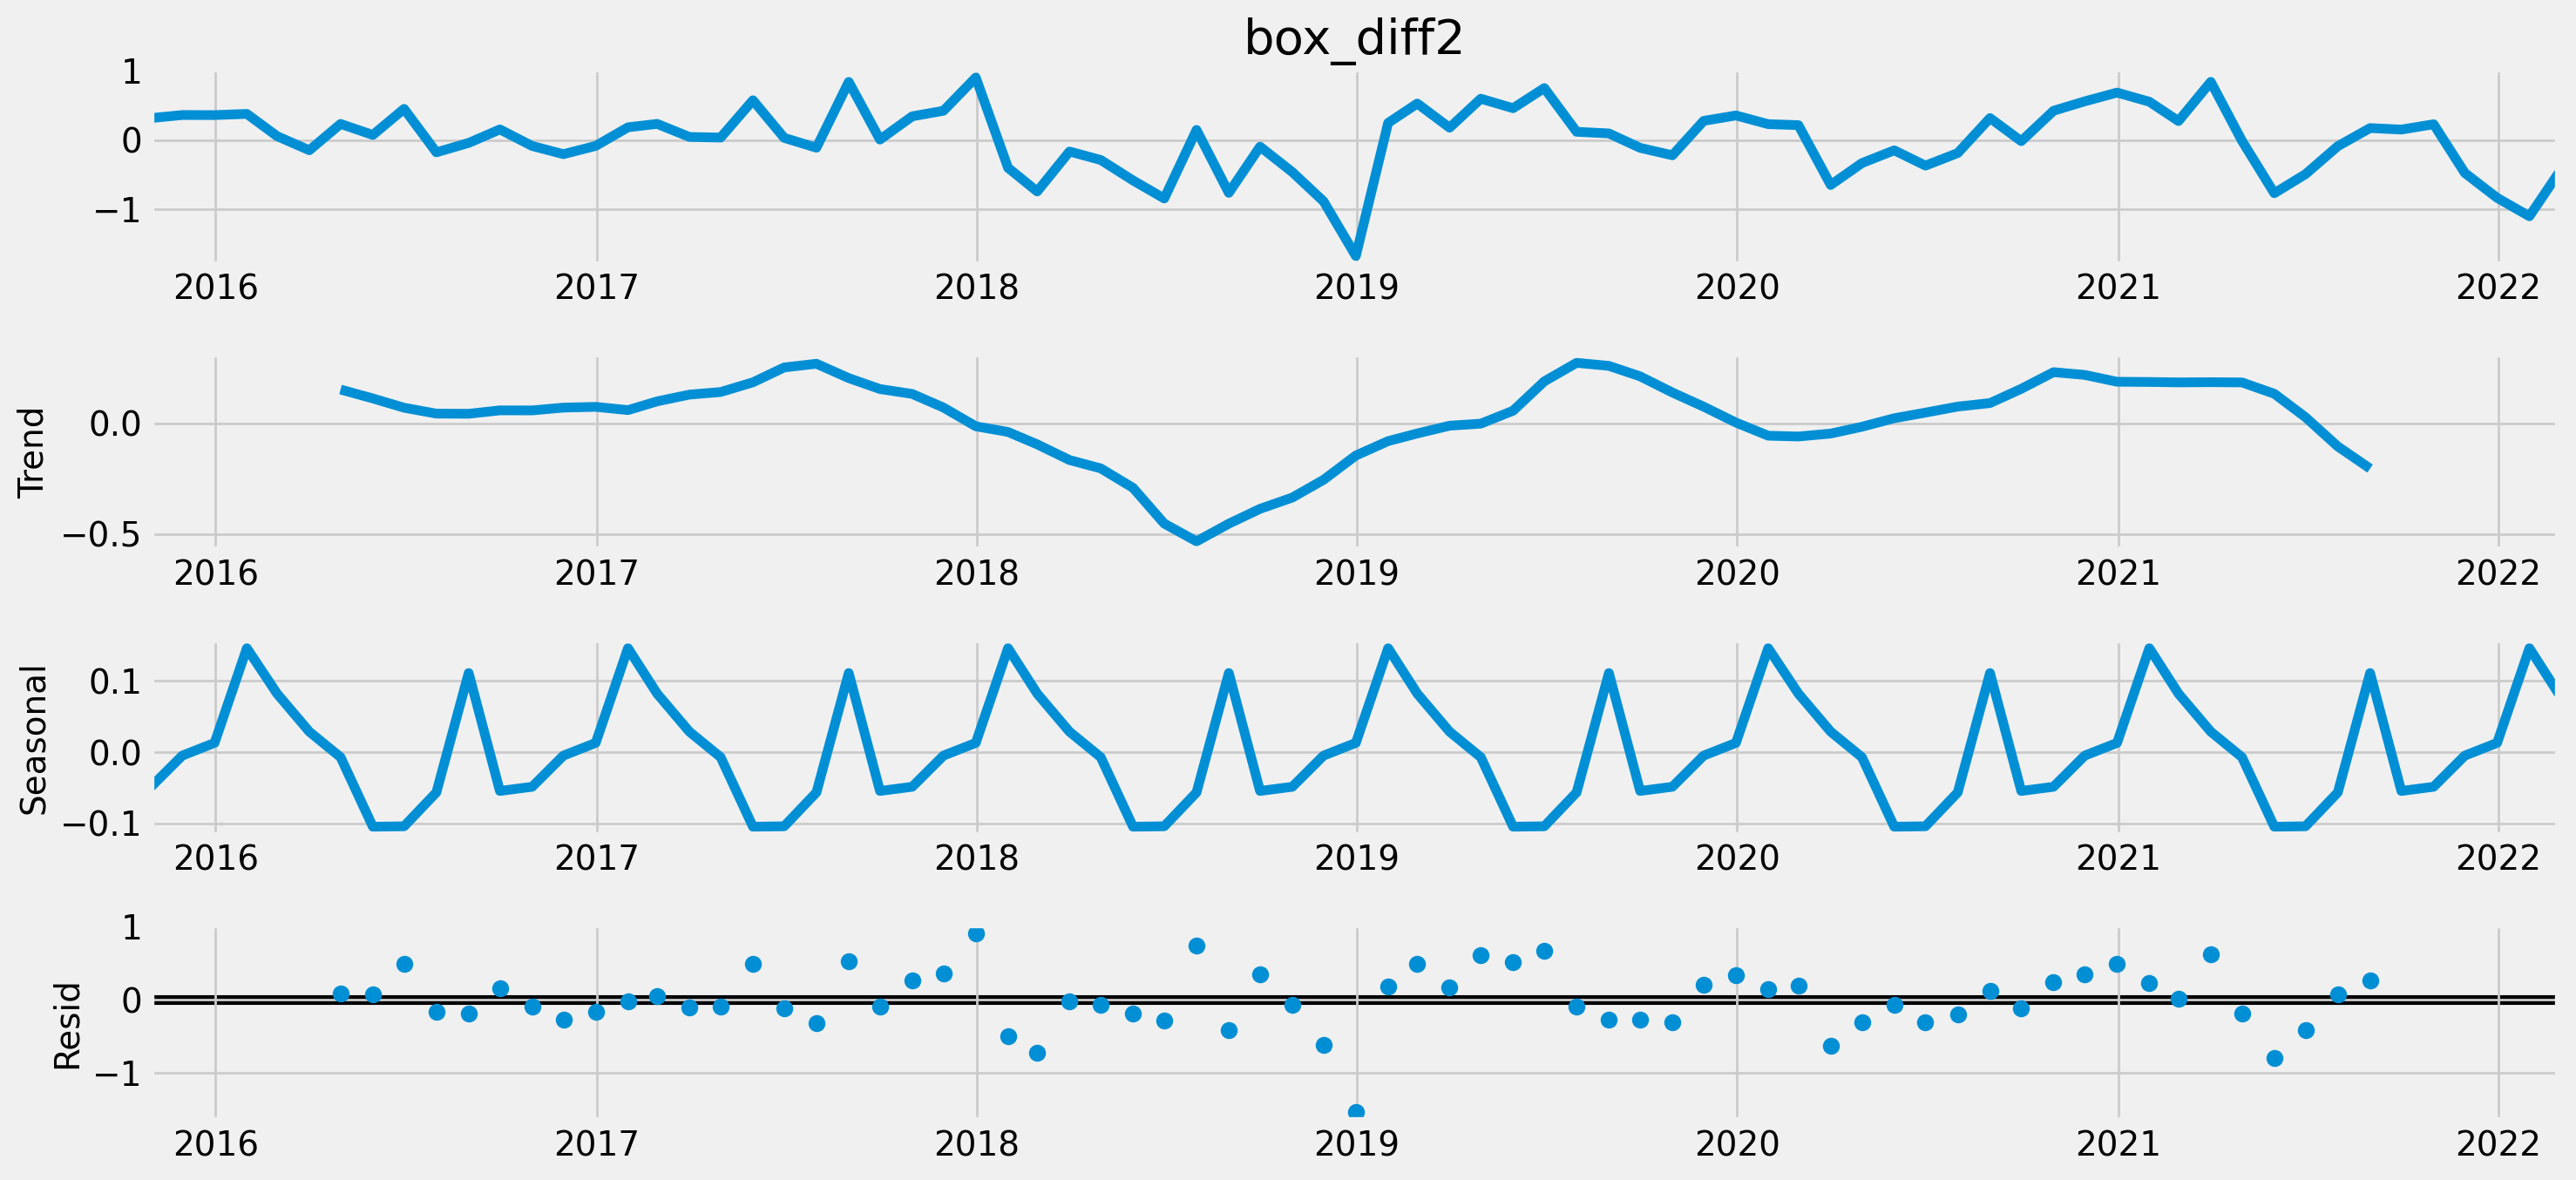

In [17]:
df_mth['box_diff2'] = (df_mth.box_diff_seasonal_12 - df_mth.box_diff_seasonal_12.shift(1))

# Seasonal and Trend decomposition using Loess decomposition [3]
seasonal_decompose(df_mth.box_diff2[13:]).plot()   
#simultaneous printing and computation ADF test
print("Augmented Dickey Fuller(ADF) test result: p = %f" % adfuller(df_mth.box_diff2[13:])[1])

plt.show()

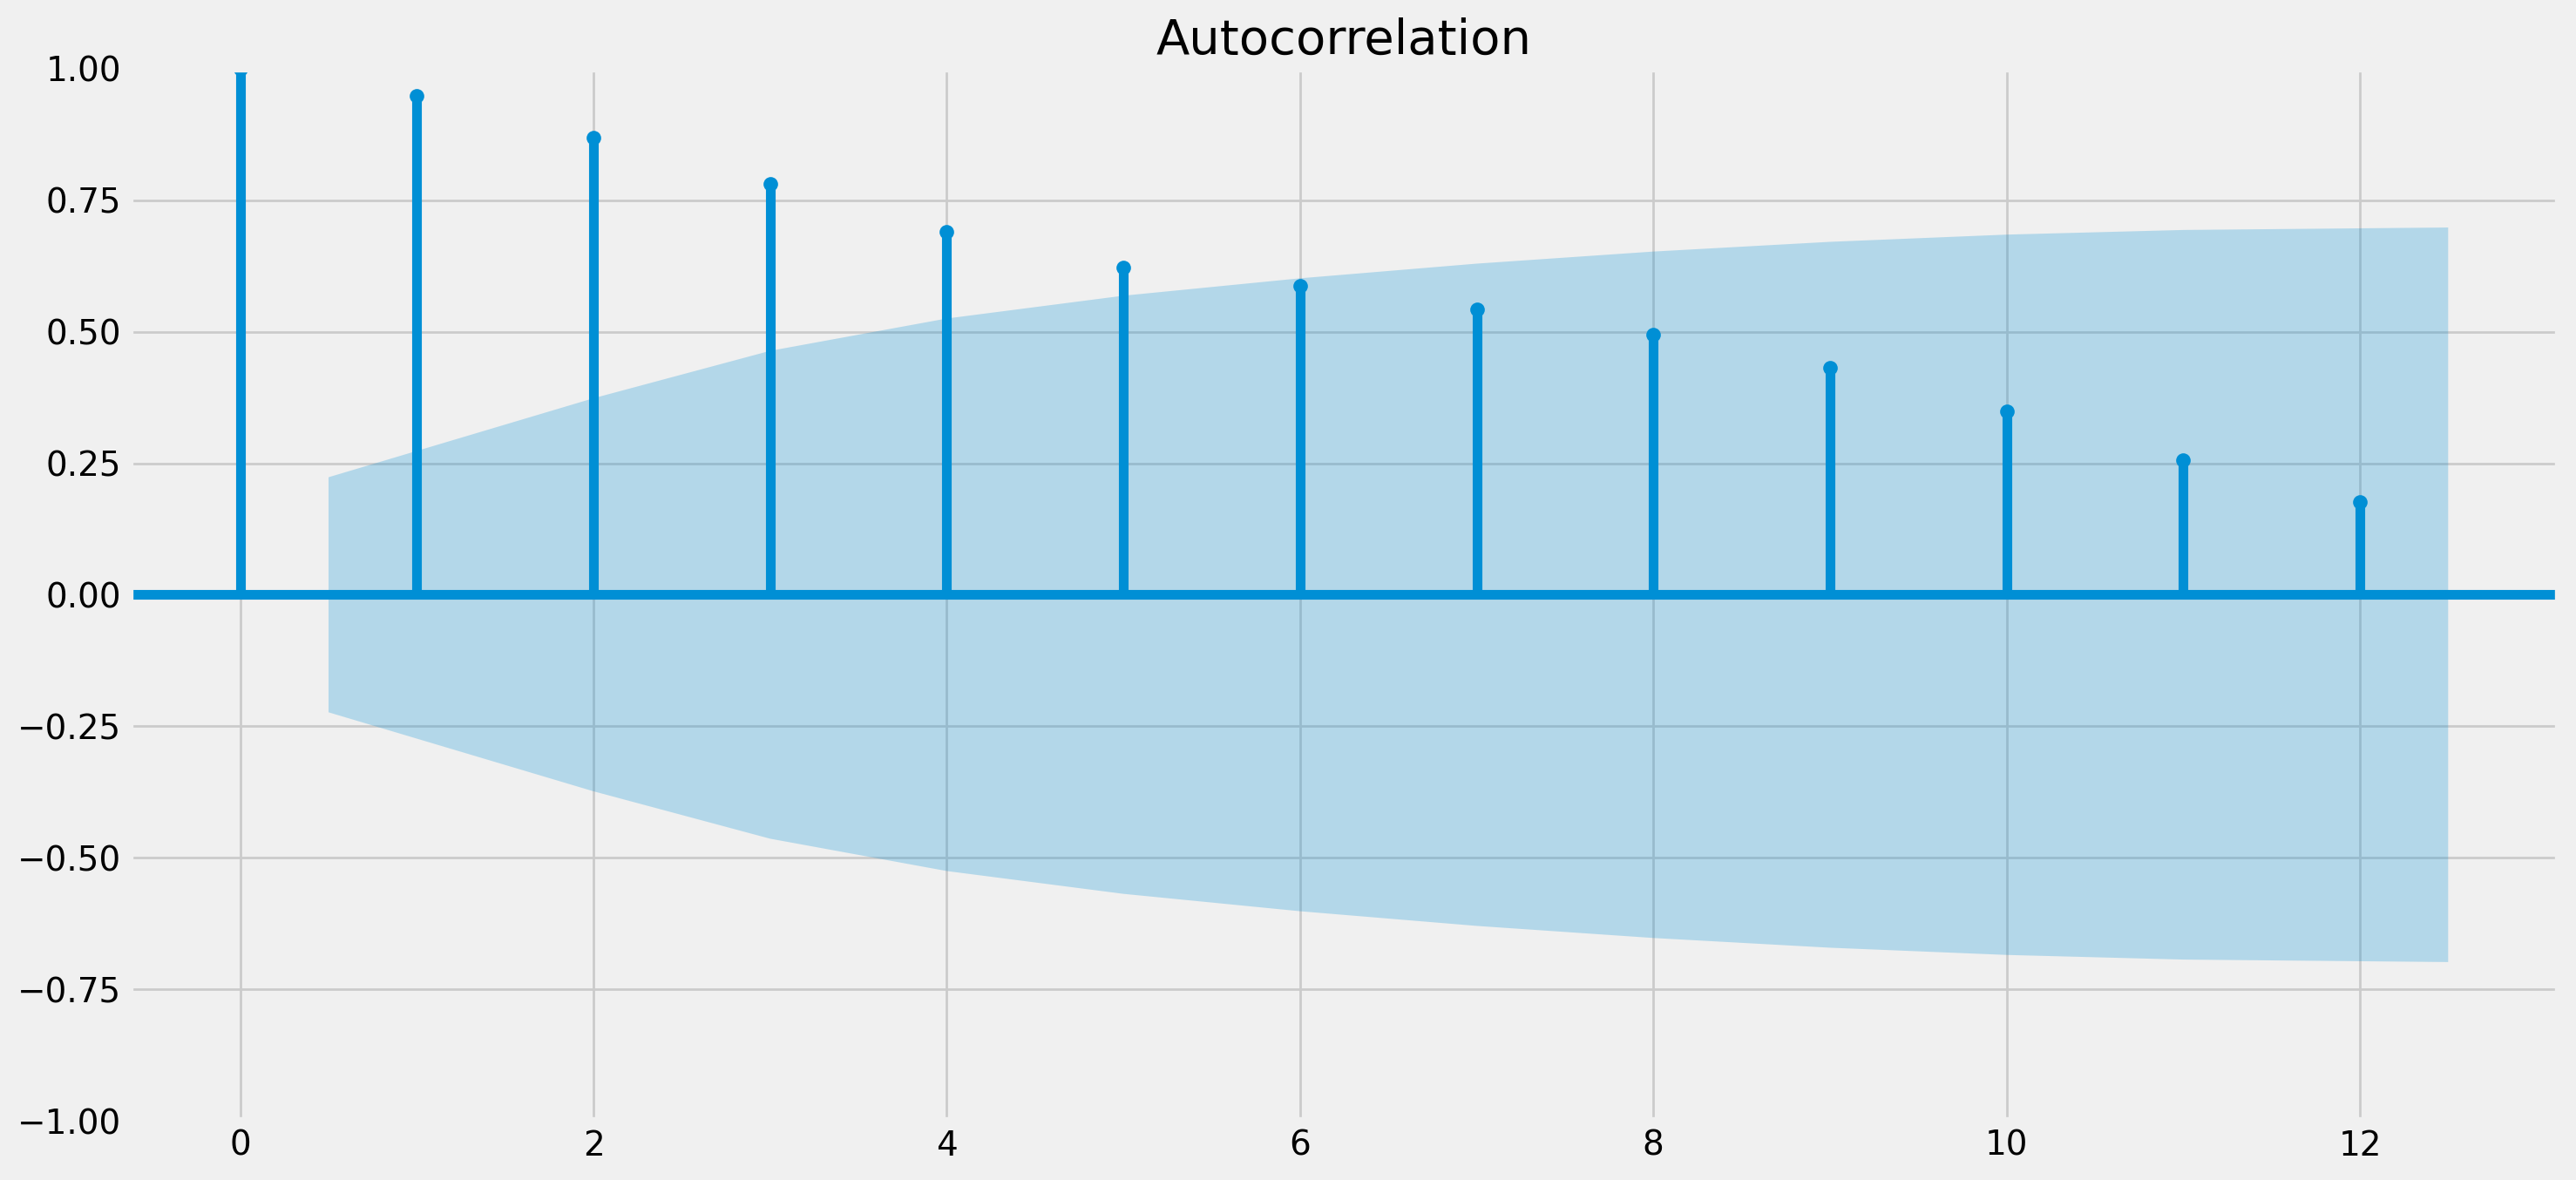

In [19]:
plot_acf(df_mth.Close[13:].values.squeeze(), lags=12)

plt.tight_layout()
plt.show()

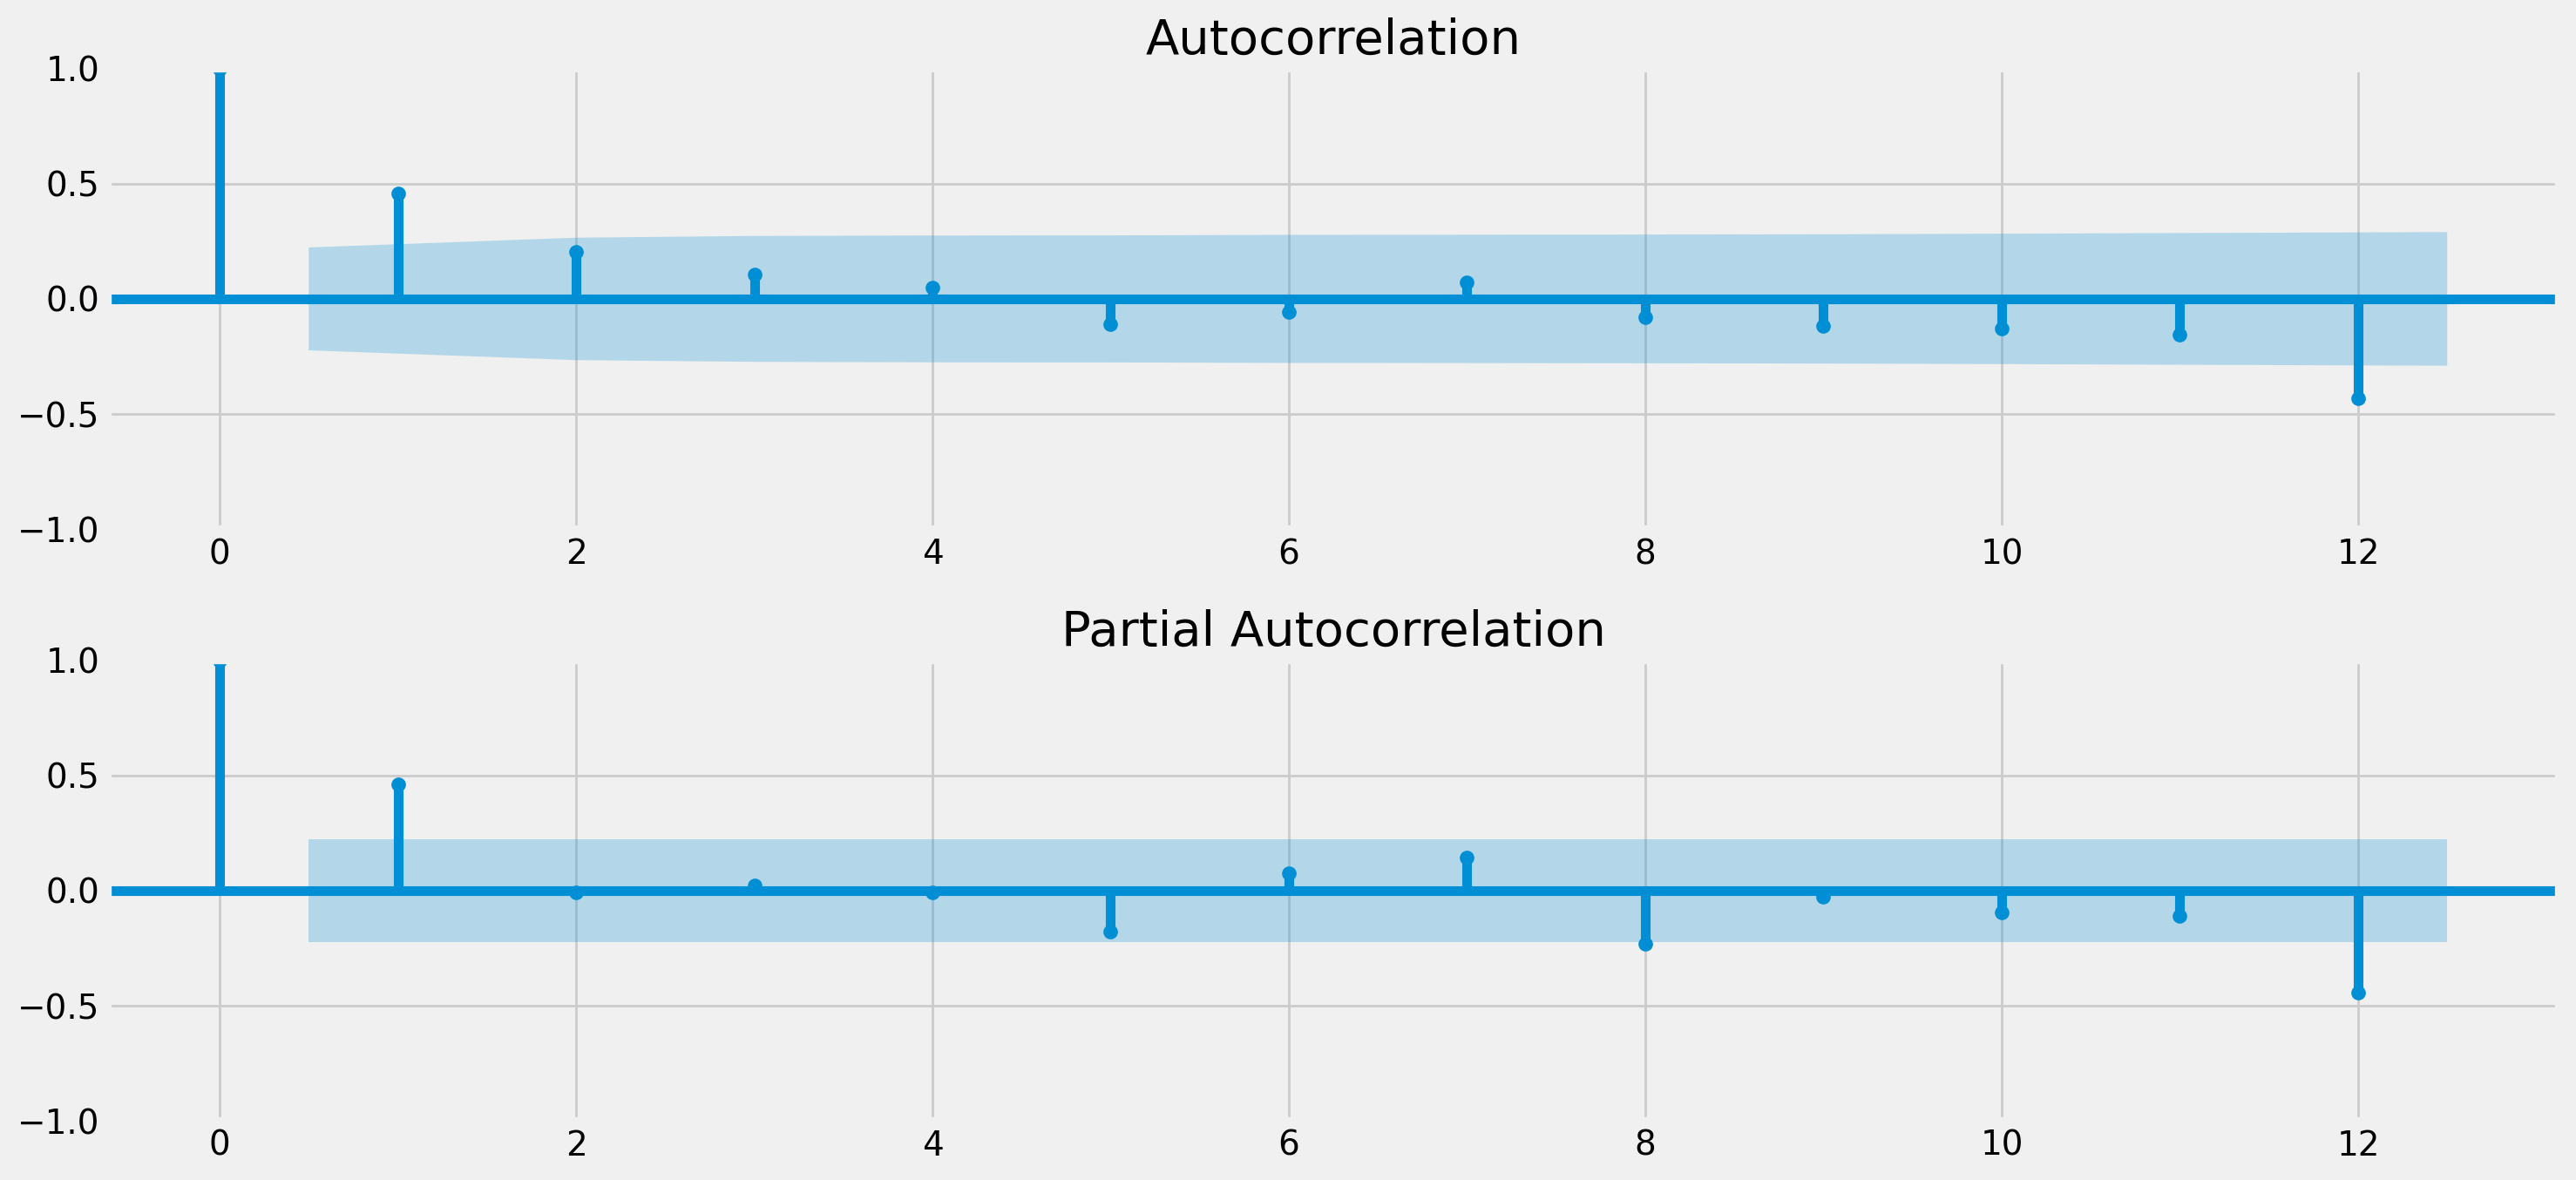

In [20]:
ax = plt.subplot(211)
# Plot the autocorrelation function [3]
plot_acf(df_mth.box_diff2[13:].values.squeeze(), lags=12, ax=ax)
ax = plt.subplot(212)
#plotting ACF graph to check for AR value autocorrelation_plot(bc_mth.close) [3]
plot_pacf(df_mth.box_diff2[13:].values.squeeze(), lags=12, ax=ax)
plt.tight_layout()
plt.show()

In [22]:
qs = range(0, 3)
ps = range(0, 3)
d=1
parameters = product(ps, qs)
parameters_list = list(parameters)
len(parameters_list)

# selecting appropriate model based on (p,d,1) parameters[3]
rslt = []
aic_bst = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model = SARIMAX(df_mth.close_box, order=(param[0], d, param[1])).fit(disp=-1)
    except ValueError:
        print('poor combination of parameters:', param)
        continue
    aic = model.aic
    if aic < aic_bst:
        mdl_bst = model
        aic_bst = aic
        params_bst = param
    rslt.append([param, model.aic])

In [23]:
rslt_table = pd.DataFrame(rslt)
#creating two columns to print values accordingly
rslt_table.columns = ['parameters', 'aic']
#sorting of values based into the relevant columns
print(rslt_table.sort_values(by = 'aic', ascending=True).head())

  parameters        aic
3     (1, 0)  34.861187
1     (0, 1)  35.828310
7     (2, 1)  36.118628
4     (1, 1)  36.805905
6     (2, 0)  36.830334


In [24]:
print(mdl_bst.summary())

                               SARIMAX Results                                
Dep. Variable:              close_box   No. Observations:                   90
Model:               SARIMAX(1, 1, 0)   Log Likelihood                 -15.431
Date:                Wed, 17 May 2023   AIC                             34.861
Time:                        23:11:16   BIC                             39.838
Sample:                    09-30-2014   HQIC                            36.867
                         - 02-28-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4039      0.073      5.496      0.000       0.260       0.548
sigma2         0.0826      0.012      7.091      0.000       0.060       0.105
Ljung-Box (L1) (Q):                   0.03   Jarque-

In [25]:
print("Augmented Dickey Fuller(ADF) test result:: p=%f" % adfuller(mdl_bst.resid[13:])[1])

Augmented Dickey Fuller(ADF) test result:: p=0.000000


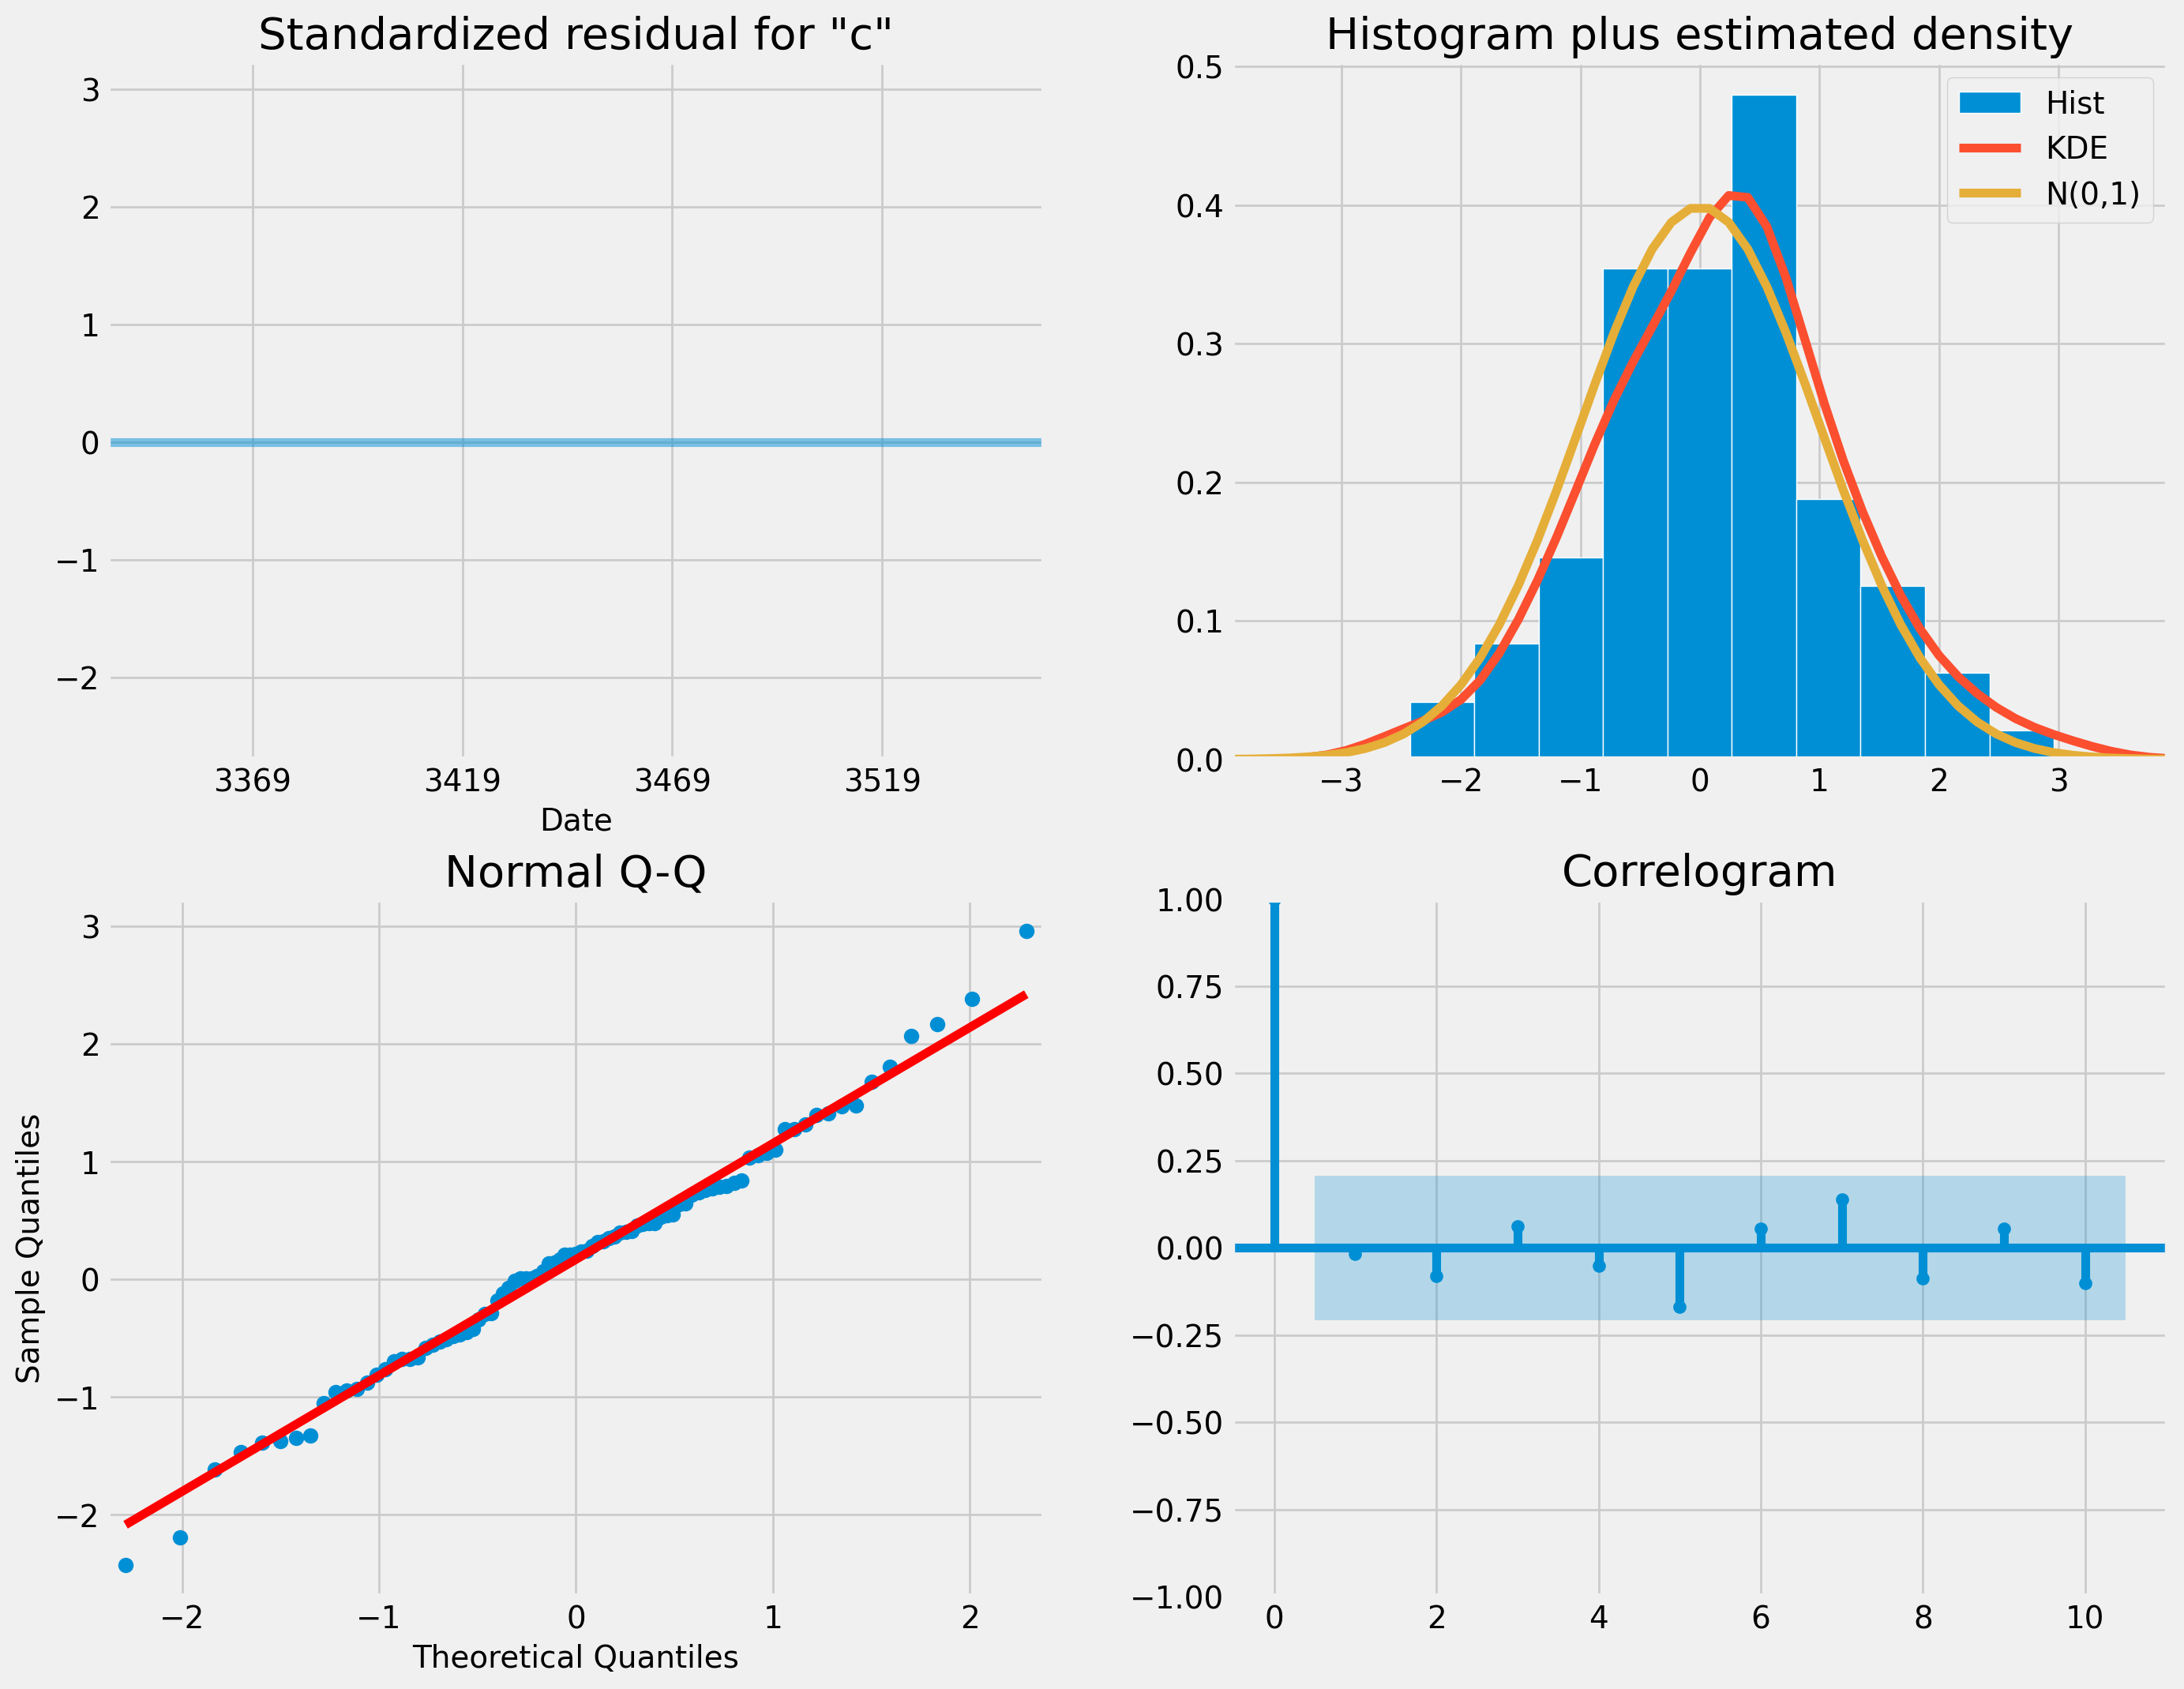

In [26]:
mdl_bst.plot_diagnostics(figsize=(15, 12))
plt.show()

In [27]:
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

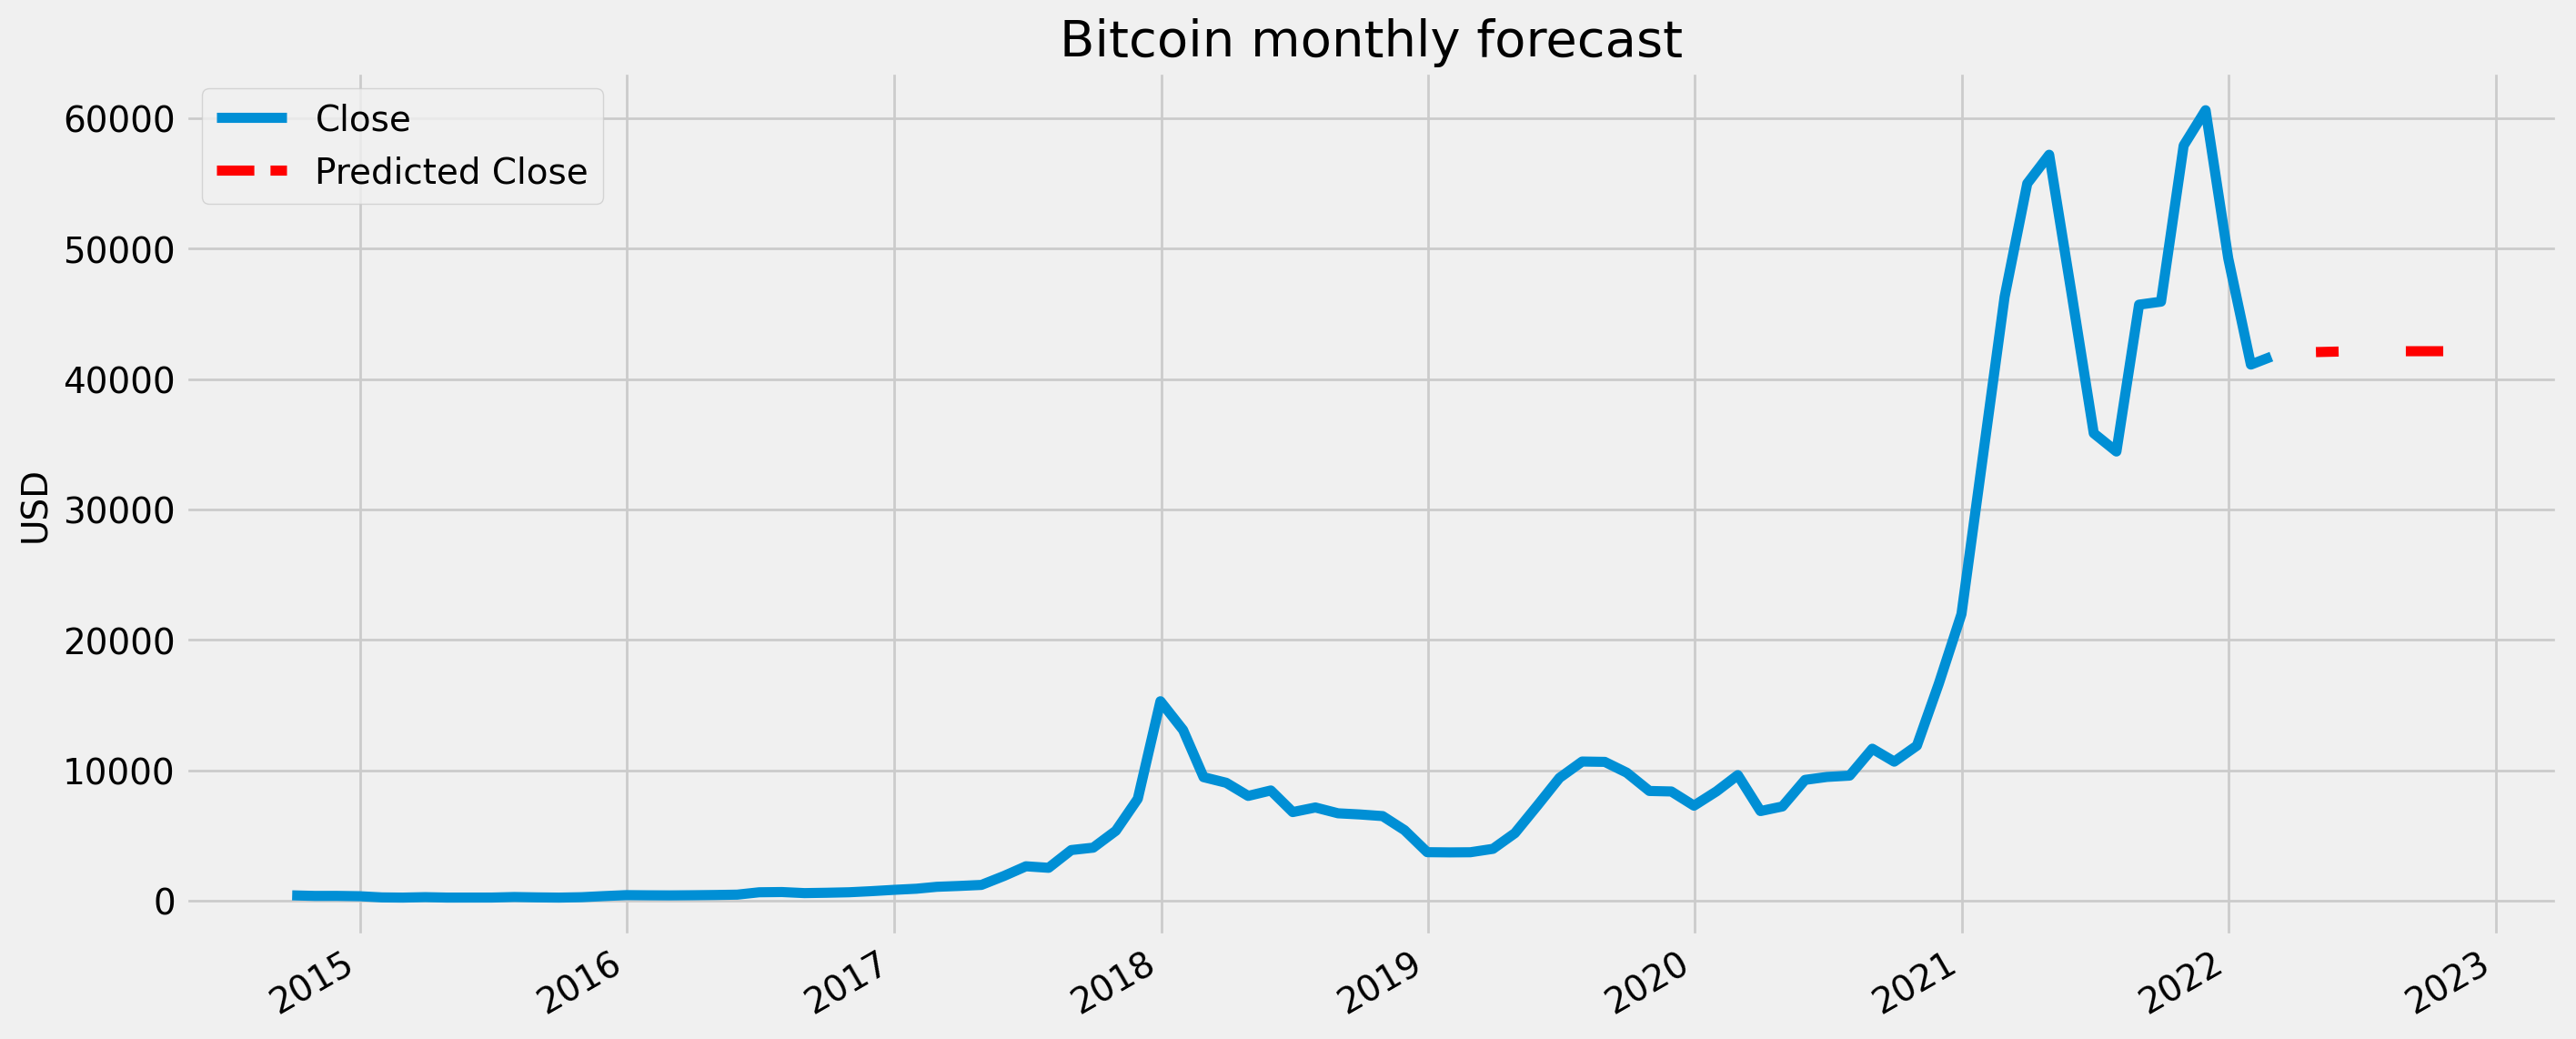

In [36]:
#storing the predictions into a new dataframe
df_mth_pred = df_mth[['Close']]
#creating a list of dates to predict prices for a particular range
date_list = [datetime(2022, 3, 1), datetime(2022, 3, 15), datetime(2022, 3, 31), datetime(2022, 4, 8), 
             datetime(2022, 4, 30), datetime(2022, 5, 31), datetime(2022, 7, 30), datetime(2022, 8, 31),
             datetime(2022, 9, 30), datetime(2022, 10, 31)]
#date_list = [datetime(2018, 3, 31), datetime(2018, 4, 30), datetime(2018, 5, 31), datetime(2018, 6, 30)]
#new dataframe with stored predictions over a period of time
future = pd.DataFrame(index=date_list, columns= df_mth.columns)
df_mth_pred = pd.concat([df_mth_pred, future])

#monthly forecasting of the values of Bitcoin's close prices
#bc_mth_pred['forecast'] = invboxcox(mdl_bst.predict(start=0, end=75), lmbda)
df_mth_pred['forecast'] = invboxcox(mdl_bst.predict(start=datetime(2022, 3, 1), end=datetime(2022, 10, 31)), lmbda)


plt.figure(figsize=(15,7))
df_mth_pred.Close.plot()
df_mth_pred.forecast.plot(color='r', ls='--', label='Predicted Close')
plt.legend()
plt.title('Bitcoin monthly forecast')
plt.ylabel('USD')
plt.show()

In [ ]:
y_forecastd = df_mth.forecast
#storing the actual close price values
y_truth = df_mth['2015-01-01':'2017-01-01'].close

# implementing the root mean square error
rmse = np.sqrt(((y_forecastd - y_truth)**2).mean())
print('Mean Squared Error: {}'.format(round(rmse, 2)))